### **Damage Classification code**


In [ ]:
pip install gradio

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# import datasets
import pathlib
dataset_path = "/content/drive/MyDrive/DLW/dlw/tier3"
train_data_dir = pathlib.Path(dataset_path+"/images")
test_data_dir = pathlib.Path(dataset_path+"/images")

train_files = glob.glob(r''+dataset_path+"/images/*.png")
train_files = list(filter(lambda x: "post" in x, train_files))
train_files = random.sample(train_files, 1500)
# train_files = random.sample(train_files, 250)
train_datasize = len(train_files)
print("training data:", len(train_files))

test_files = glob.glob(r''+dataset_path+"/images/*.png")
test_files = list(filter(lambda x: "post" in x, test_files))
test_files = random.sample(test_files, 500)
# test_files = random.sample(test_files, 100)
test_datasize = len(test_files)
print("test data:", len(test_files))

training data: 1500
test data: 500


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images = list(train_data_dir.glob('*'))
random_image = random.choice(images)
im = PIL.Image.open(str(random_image))

width, height = im.size
print(width)
print(height)
im.resize((300, 300)).show()

1024
1024


In [ ]:
img_height = 1024
img_width = 1024
class_names = np.array(sorted(['volcano', 'flooding', 'earthquake', 'fire', 'wind', 'tsunami']))
print(class_names)



['earthquake' 'fire' 'flooding' 'tsunami' 'volcano' 'wind']


In [ ]:
def get_label(file_path, type):
    #parts = file_path.split(os.path.sep)
    print(parts)
    # path = dataset_path+'/train/labels/'
    path = dataset_path+'/labels/'
    if type == "test":
        # path = dataset_path+'/test/labels/'
        path = dataset_path+'/labels/'
    f = open(path + parts[8].split('.')[0] +'.json')
    data = json.load(f)
    disaster_type = data['metadata']['disaster_type'] 
    f.close()

    label = disaster_type == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot


def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [15]:
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img= PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("train")
print(train_X.shape)
print(train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img= PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("test")
print(test_X.shape)
print(test_Y.shape)


['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'joplin-tornado_00000040_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'lower-puna-volcano_00000143_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'nepal-flooding_00000114_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'portugal-wildfire_00000441_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'portugal-wildfire_00000033_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'woolsey-fire_00000015_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'pinery-bushfire_00000156_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'tuscaloosa-tornado_00000017_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'piner

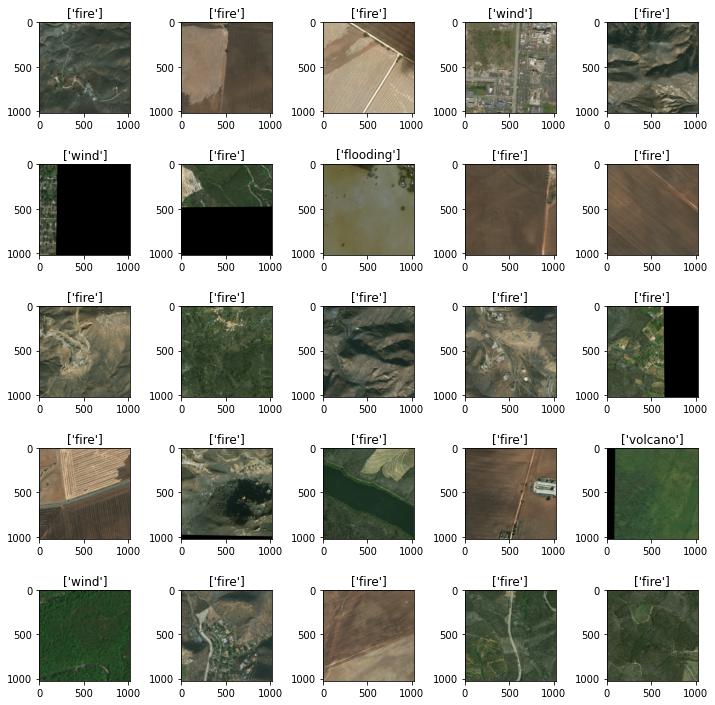

In [16]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)    
    choice = random.randint(0, train_datasize-1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()



In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax"),
])

In [18]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 1024, 1024, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 512, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1

In [19]:
epochs = 5
batch_size = 5
history = model.fit(
  train_X,
  train_Y,
  validation_data=(test_X, test_Y),
  epochs=epochs,
  batch_size=batch_size
)


Epoch 1/5
300/300 [==============================] - 2145s 7s/step - loss: 1.2231 - accuracy: 0.7127 - val_loss: 0.7200 - val_accuracy: 0.7640
Epoch 2/5
300/300 [==============================] - 2121s 7s/step - loss: 0.8553 - accuracy: 0.7587 - val_loss: 0.7103 - val_accuracy: 0.7840
Epoch 3/5
300/300 [==============================] - 2145s 7s/step - loss: 0.6916 - accuracy: 0.8260 - val_loss: 0.8913 - val_accuracy: 0.8320
Epoch 4/5
300/300 [==============================] - 2151s 7s/step - loss: 0.2986 - accuracy: 0.9207 - val_loss: 1.1757 - val_accuracy: 0.8520
Epoch 5/5
300/300 [==============================] - 2178s 7s/step - loss: 0.1257 - accuracy: 0.9613 - val_loss: 1.0569 - val_accuracy: 0.8080


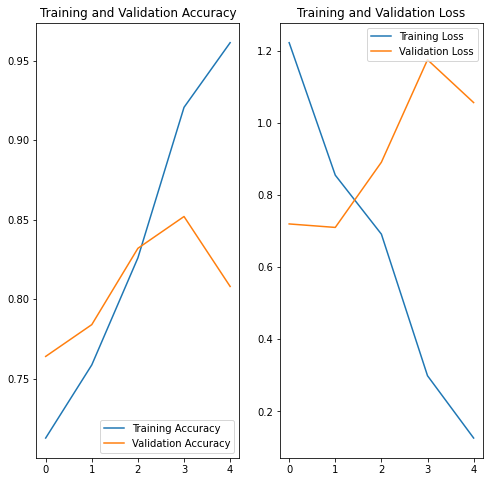

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [20]:
model.save("damage-classification-model-real.h5", include_optimizer=False)


In [22]:
def disaster_classification(img):
    print(img.shape)
    image = np.zeros((1, 1024, 1024, 3), dtype=np.uint8)
    image[0] = img
    prediction = model.predict(image).tolist()[0]
    print(prediction)
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

iface = gr.Interface(
    fn = disaster_classification,
    inputs = gr.inputs.Image(shape=(1024, 1024), image_mode='RGB', invert_colors=False, source="upload", type='numpy'), 
    outputs = gr.outputs.Label(),
    allow_screenshot=False, 
    allow_flagging='never'
)
iface.launch(share=True, show_error=True, inline=True, debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  "Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
 

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://19639.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(1024, 1024, 3)
[3.789981131463217e-33, 0.00047985644778236747, 0.11570459604263306, 3.1201827368931845e-05, 0.88347327709198, 0.0003109988756477833]
(1024, 1024, 3)
[0.0, 0.006576902698725462, 0.9537767767906189, 3.1397880206895934e-07, 0.03294616565108299, 0.00669983122497797]
Keyboard interruption in main thread... closing server.


(<gradio.routes.App at 0x7f9726d98850>,
 'http://127.0.0.1:7860/',
 'https://19639.gradio.app')

### ***Damage Classification Code***


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
import pathlib
# dataset_path = "./xBD-dataset"
dataset_path = "/content/drive/MyDrive/DLW/dlw/tier3"
# train_data_dir = pathlib.Path(dataset_path+"/train/images")
# test_data_dir = pathlib.Path(dataset_path+"/test/images")
train_data_dir = pathlib.Path(dataset_path+"/images")
test_data_dir = pathlib.Path(dataset_path+"/images")


# train_files = glob.glob(r""+dataset_path+"/train/images/*.png")
train_files = glob.glob(r""+dataset_path+"/images/*.png")
train_files = random.sample(train_files, 1500)
# train_files = random.sample(train_files, 50)
train_datasize = len(train_files)
print("training data:", len(train_files))

# test_files = glob.glob(r""+dataset_path+"/test/images/*.png")
test_files = glob.glob(r""+dataset_path+"/images/*.png")
test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("test data:", len(test_files))



training data: 1500
test data: 500


In [3]:
images = list(train_data_dir.glob('*'))
random_image = random.choice(images)
im = PIL.Image.open(str(random_image))

width, height = im.size
print(width)
print(height)
im.resize((300, 300)).show()



1024
1024


In [4]:
img_height = 1024
img_width = 1024
class_names = np.array(sorted(['disaster happened', 'no disaster happened']))
print(class_names)


['disaster happened' 'no disaster happened']


In [5]:


def get_label(file_path, type):
    parts = file_path.split(os.path.sep)
    print(parts)

    if "pre" in parts[8]:
      damage = 'no disaster happened'
    else: # "post"
      damage = 'disaster happened'

    label = damage == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot


def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]



In [6]:


train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img= PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("train")
print(train_X.shape)
print(train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img= PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("test")
print(test_X.shape)
print(test_Y.shape)



['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'portugal-wildfire_00000647_pre_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'woolsey-fire_00000517_pre_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'portugal-wildfire_00001018_pre_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'portugal-wildfire_00000346_pre_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'portugal-wildfire_00000197_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'portugal-wildfire_00000519_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'pinery-bushfire_00001704_pre_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'pinery-bushfire_00001014_post_disaster.png']
['', 'content', 'drive', 'MyDrive', 'DLW', 'dlw', 'tier3', 'images', 'woolsey-

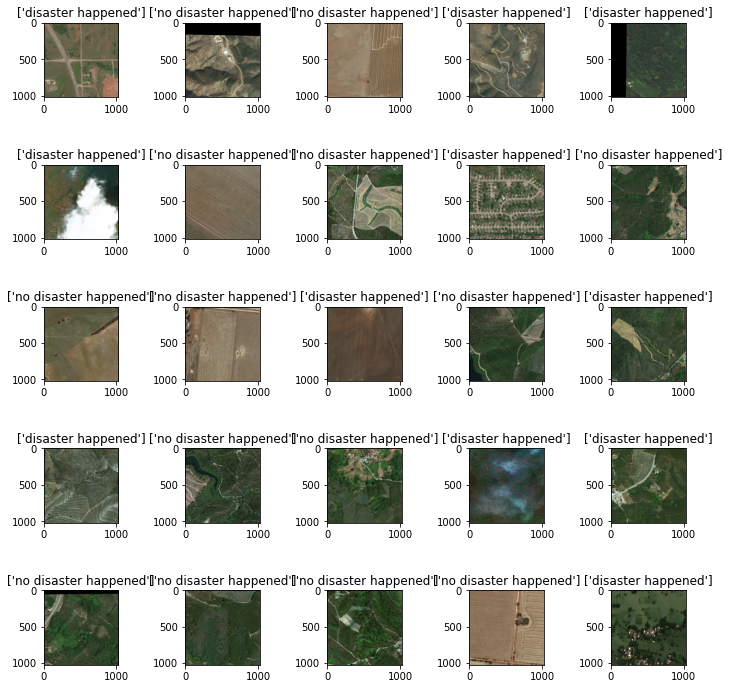

In [7]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)    
    choice = random.randint(0, train_datasize-1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()



In [8]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax"),
])



In [9]:
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 1024, 1024, 3)     0         
                                                                 
 conv2d (Conv2D)             (None, 1024, 1024, 16)    448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 512, 512, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 256, 256, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 64)      1

In [12]:
epochs = 5
batch_size = 5
history = model.fit(
  train_X,
  train_Y,
  validation_data=(test_X, test_Y),
  epochs=epochs,
  batch_size=batch_size
)



Epoch 1/5
300/300 [==============================] - 2327s 8s/step - loss: 0.6925 - accuracy: 0.5247 - val_loss: 0.6889 - val_accuracy: 0.5360
Epoch 2/5
300/300 [==============================] - 2328s 8s/step - loss: 0.6903 - accuracy: 0.5360 - val_loss: 0.6826 - val_accuracy: 0.5720
Epoch 3/5
300/300 [==============================] - 2323s 8s/step - loss: 0.6869 - accuracy: 0.5507 - val_loss: 0.6849 - val_accuracy: 0.5980
Epoch 4/5
300/300 [==============================] - 2330s 8s/step - loss: 0.6854 - accuracy: 0.5847 - val_loss: 0.6810 - val_accuracy: 0.5420
Epoch 5/5
300/300 [==============================] - 2351s 8s/step - loss: 0.6570 - accuracy: 0.6360 - val_loss: 0.6999 - val_accuracy: 0.5760


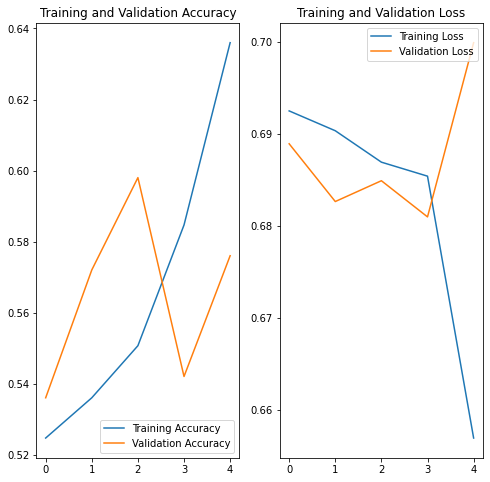

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
model.save("damage-detection-model-real.h5", include_optimizer=False)

In [ ]:
def damage_classification(img):
    print(img.shape)
    image = np.zeros((1, 1024, 1024, 3), dtype=np.uint8)
    image[0] = img
    prediction = model.predict(image).tolist()[0]
    print(prediction)
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

iface = gr.Interface(
    fn = damage_classification,
    inputs = gr.inputs.Image(shape=(1024, 1024), image_mode='RGB', invert_colors=False, source="upload", type='numpy'), 
    outputs = gr.outputs.Label(),
    allow_screenshot=False, 
    allow_flagging='never'
)
iface.launch(share=True, show_error=True, inline=True, debug=True)


### Damage Extent Classification


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image, ImageFile
import tensorflow as tf
import json
import glob
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import gradio as gr
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
import pathlib
dataset_path = "./xBD-dataset"
train_data_dir = pathlib.Path(dataset_path+"/train/images")
test_data_dir = pathlib.Path(dataset_path+"/test/images")

train_files = glob.glob(r""+dataset_path+"/train/images/*.png")
train_files = list(filter(lambda x: "post" in x, train_files))
train_files = random.sample(train_files, 1500)
train_datasize = len(train_files)
print("training data:", len(train_files))

test_files = glob.glob(r""+dataset_path+"/test/images/*.png")
test_files = list(filter(lambda x: "post" in x, test_files))
test_files = random.sample(test_files, 500)
test_datasize = len(test_files)
print("test data:", len(test_files))

In [ ]:


images = list(train_data_dir.glob('*'))
random_image = random.choice(images)
im = PIL.Image.open(str(random_image))

width, height = im.size
print(width)
print(height)
im.resize((300, 300)).show()



In [ ]:
img_height = 1024
img_width = 1024
class_names = np.array(['no damage', 'minor damage', 'major damage', 'destroyed'])
print(class_names)

In [ ]:
def get_label(file_path, type):
    parts = file_path.split(os.path.sep)

    path = dataset_path+'/train/labels/'
    if type == "test":
        path = dataset_path+'/test/labels/'
    f = open(path + parts[7].split('.')[0] +'.json')
    data = json.load(f)

    building_list = data["features"]["xy"]
    total_damage_level = 0 
    for i in range(len(building_list)):
      building = building_list[i]
      damage_level = building['properties']['subtype']
      if damage_level == 'no-damage':
        total_damage_level += 0
      elif damage_level == 'minor-damage':
        total_damage_level += 1
      elif damage_level == 'major-damage':
        total_damage_level += 2
      else:
        total_damage_level += 3
    f.close()
    
    average_damage_level = total_damage_level
    if len(building_list) > 0:
      average_damage_level /= len(building_list)

    label = class_names[round(average_damage_level)] == class_names
    one_hot = np.zeros(len(class_names), dtype=np.uint8)
    one_hot[label] = 1

    return one_hot


def get_label_from_one_hot(array):
    return class_names[np.where(array == 1)]

In [ ]:
train_X = np.zeros((train_datasize, img_height, img_width, 3), dtype=np.uint8)
train_Y = np.zeros((train_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(train_files)):
    img= PIL.Image.open(train_files[i])
    train_X[i] = np.array(img)
    train_Y[i] = get_label(train_files[i], "train")
print("train")
print(train_X.shape)
print(train_Y.shape)

test_X = np.zeros((test_datasize, img_height, img_width, 3), dtype=np.uint8)
test_Y = np.zeros((test_datasize, len(class_names)), dtype=np.uint8)

for i in range(len(test_files)):
    img= PIL.Image.open(test_files[i])
    test_X[i] = np.array(img)
    test_Y[i] = get_label(test_files[i], "test")
print("test")
print(test_X.shape)
print(test_Y.shape)

In [ ]:


plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)    
    choice = random.randint(0, train_datasize-1)
    plt.title(get_label_from_one_hot(train_Y[choice]))
    plt.imshow(train_X[choice])

plt.tight_layout()
plt.show()



In [ ]:


num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation="softmax"),
])



In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [ ]:


epochs = 5
batch_size = 5
history = model.fit(
  train_X,
  train_Y,
  validation_data=(test_X, test_Y),
  epochs=epochs,
  batch_size=batch_size
)



In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [ ]:
model.save("regional-damage-classification-model.h5")


In [ ]:
def disaster_classification(img):
    print(img.shape)
    image = np.zeros((1, 1024, 1024, 3), dtype=np.uint8)
    image[0] = img
    prediction = model.predict(image).tolist()[0]
    print(prediction)
    return {class_names[i]: prediction[i] for i in range(len(class_names))}

iface = gr.Interface(
    fn = disaster_classification,
    inputs = gr.inputs.Image(shape=(1024, 1024), image_mode='RGB', invert_colors=False, source="upload", type='numpy'), 
    outputs = gr.outputs.Label(),
    allow_screenshot=False, 
    allow_flagging='never'
)
iface.launch(share=True, show_error=True, inline=True, debug=True)
